In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm
from time import sleep
import torchvision
import torch_geometric.nn as pyg_nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
features_covid = torch.load(r'C:\Users\hvard\Desktop\Neeraj_work\Neeraj_work\covid.pt', map_location=torch.device('cpu'))
features_noncovid = torch.load(r'C:\Users\hvard\Desktop\Neeraj_work\Neeraj_work\health.pt',map_location=torch.device('cpu'))

In [4]:
train_labels = torch.zeros((features_covid.shape[0]))
test_labels = torch.ones((features_noncovid.shape[0]))

In [5]:
train_feats = []
train_label = []
for i in range(250,len(test_labels)):
    train_feats.append(features_covid[i])
    train_feats.append(features_noncovid[i])
    train_label.append(train_labels[i])
    train_label.append(test_labels[i])

In [6]:
test_feats = []
test_label = []

In [7]:
for i in range(0,250):
    test_feats.append(features_covid[i])
    test_feats.append(features_noncovid[i])
    test_label.append(train_labels[i])
    test_label.append(test_labels[i])

In [8]:
train_feats = torch.stack(train_feats)
train_label = torch.stack(train_label)
test_feats = torch.stack(test_feats)
test_label = torch.stack(test_label)

In [9]:
features_train = train_feats.unsqueeze(1)
features_test = test_feats.unsqueeze(1)

In [10]:
train_label = train_label.to(torch.long)
test_label = test_label.to(torch.long)

In [11]:
features_train.shape

torch.Size([1958, 1, 128])

In [21]:
from torch.utils.data import Dataset, DataLoader

class FeatureDataset(Dataset):
  """
  This is a custom dataset class to generate feature dataset to load into models
  """
  def __init__(self, X, Y):
    features = []
    labels = []
    
    for i in range(0,X.shape[0]):
      temp = X[i]
      features.append(temp)
      s = torch.stack(features)
      self.X = s
      temp1 = Y[i]
      labels.append(temp1)
      t = torch.stack(labels)
      self.Y = t

    
    if len(self.X) != len(self.Y):
        raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    x = self.X[index]
    y = self.Y[index]

    return x, y

In [31]:
# Learning rate parameters
BASE_LR = 0.0001
EPOCH_DECAY = 5 # number of epochs after which the Learning rate is decayed exponentially.
DECAY_WEIGHT = 0.5 # factor by which the learning rate is reduced.


# DATASET INFO
NUM_CLASSES = 2 # set the number of classes in your dataset
VALID_SPLIT = 0.8

# DATALOADER PROPERTIES
BATCH_SIZE = 256 # Set as high as possible. If you keep it too high, you'll get an out of memory error.

In [32]:
#dataset for train and val
dataset = FeatureDataset(features_train, train_label)
dataset

In [33]:
torch.save(dataset,'features_dataset_CTScans.pt')

In [34]:
#dataset for test
test_data = FeatureDataset(features_test,test_label)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)
print(test_loader)

In [35]:
len(dataset)

1958

In [36]:
SIZE =0.8
a = int(SIZE * len(dataset))
b = len(dataset)- a
train_data, val_data = torch.utils.data.random_split(dataset,[a,b])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True)
print(len(train_loader),len(val_loader))

7 2


In [37]:
#k = 21

def nearestneighbours(features,k):
    neighbour = NearestNeighbors(n_neighbors=k)
    features = features.cpu().detach().numpy()
    features = features.squeeze()
    neighbour.fit(features)
    temp_matrix = neighbour.kneighbors_graph(features)
    temp_matrix = temp_matrix.toarray()
    temp_matrix = torch.from_numpy(temp_matrix)
    temp_matrix = temp_matrix.to(device)

    return temp_matrix

In [38]:
def edge_finder(matrix):
    matrix = matrix.cpu()
    m = matrix.numpy().squeeze()
    edge = []
    
    for i in range(0,matrix.shape[0]):
        for j in range(0,matrix.shape[0]):
            if(m[i][j] == 1):
                x = i,j
                edge.append(x)

    edge = np.array(edge)
    edge  = torch.from_numpy(edge)
    edge = edge.T
    edge = edge.to(torch.long) 
    edge = edge.to(device)   
    return(edge)

In [39]:
class GNN(nn.Module):
    
    def __init__(self, c_in, c_out):
        super().__init__()
        print(c_in,c_out)
        self.projection = nn.Linear(c_in, c_out)
        self.fc1 = nn.Linear(128, 2)
    
    
    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
            #print(node_feats.shape)
            #batch = node_feats.shape[0]
        node_feats = self.projection(node_feats.float())
        node_feats = torch.matmul(adj_matrix.float(), node_feats)
        node_feats = node_feats / num_neighbours        
        x = self.fc1(node_feats.float())
        #x = F.relu(x)
        #x = F.dropout(x,p=0.5)
        out = F.softmax(x, dim=2)
            
            #print("This is out",out)
        return out 

    def loss(self, pred, label):
        loss1 = nn.CrossEntropyLoss()
        return loss1(pred, label)

In [40]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, k
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'k':k
                }, 'best_model_features.pth')

In [41]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'final_model_features.pth')

In [42]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='dotted', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='dotted', 
        label='validataion accuracy'
    )
    #plt.ylim([60,100])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.legend()
    plt.savefig('accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='dotted', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='dotted', 
        label='validataion loss'
    )
    #plt.ylim([0,0.6])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()

In [43]:
gnn = GNN(c_in=features_train.shape[2], c_out=features_train.shape[2])
gnn.projection.weight.data = nn.init.xavier_uniform_(torch.rand(features_train.shape[2],features_train.shape[2]))
gnn.projection.bias.data = torch.rand(features_train.shape[2])
gnn

128 128


GNN(
  (projection): Linear(in_features=128, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)

In [44]:
model = gnn
model = model.to(device)
# optimizer
optimizer_ft = optim.RMSprop(model.parameters(), lr=0.0001)
# loss function
criterion = nn.CrossEntropyLoss()
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
# initialize SaveBestModel class
save_best_model = SaveBestModel()
print(model)

16,770 total parameters.
GNN(
  (projection): Linear(in_features=128, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)


In [45]:
# training
def train(model, trainloader, optimizer, criterion,k):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        features = features.squeeze()
        adj_matrix = nearestneighbours(features,k)
        adj_matrix = adj_matrix.to(device)
        #edge = edge_finder(adj_matrix)        
        outputs = model(features.unsqueeze(0),adj_matrix.unsqueeze(0))
        #outputs = model(feats, adj_matrix, edge, 0)
        outputs = outputs.squeeze()
        #outputs = outputs.to(torch.long)
        #outputs = model(image)
        # calculate the loss
        labels = labels.to(torch.long)
        loss = model.loss(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward(retain_graph=True)
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [49]:
# validation
def validate(model, testloader, criterion,k):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            # forward pass
            features = features.squeeze()
            adj_matrix = nearestneighbours(features,k)
            adj_matrix = adj_matrix.to(device)
            #edge = edge_finder(adj_matrix)
            outputs = model(features.unsqueeze(0), adj_matrix.unsqueeze(0))
            #outputs = model(feats, adj_matrix, edge, 0)
            outputs = outputs.squeeze()
            #outputs = model(image)
            # forward pass
            #outputs = model(features)
            # calculate the loss
            labels = labels.to(torch.long)
            loss = model.loss(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

K =  3
[INFO]: Epoch 1 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.91it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.30it/s]


Training loss: 0.375, training acc: 93.742
Validation loss: 0.396, validation acc: 92.347

Best validation loss: 0.396106481552124

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 103.05it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.385, training acc: 93.870
Validation loss: 0.393, validation acc: 92.347

Best validation loss: 0.39294351637363434

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 84.71it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.373, training acc: 93.934
Validation loss: 0.385, validation acc: 91.837

Best validation loss: 0.3854372352361679

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.378, training acc: 93.870
Validation loss: 0.386, validation acc: 91.582
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.29it/s]


Training loss: 0.372, training acc: 94.125
Validation loss: 0.384, validation acc: 92.092

Best validation loss: 0.3838219791650772

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 46.05it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 50.00it/s]


Training loss: 0.376, training acc: 93.742
Validation loss: 0.388, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 61.64it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.48it/s]


Training loss: 0.379, training acc: 93.997
Validation loss: 0.387, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.79it/s]


Training loss: 0.368, training acc: 94.381
Validation loss: 0.391, validation acc: 91.837
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 54.68it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.42it/s]


Training loss: 0.365, training acc: 94.061
Validation loss: 0.388, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.364, training acc: 94.253
Validation loss: 0.386, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 58.33it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.375, training acc: 94.317
Validation loss: 0.378, validation acc: 92.347

Best validation loss: 0.3775070160627365

Saving best model for epoch: 11

--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 48.56it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.47it/s]


Training loss: 0.369, training acc: 94.317
Validation loss: 0.386, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 46.06it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.47it/s]


Training loss: 0.373, training acc: 94.444
Validation loss: 0.383, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 58.34it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.374, training acc: 94.317
Validation loss: 0.384, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.50it/s]


Training loss: 0.370, training acc: 94.189
Validation loss: 0.382, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 66.72it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.370, training acc: 94.189
Validation loss: 0.383, validation acc: 91.837
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 58.33it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.363, training acc: 94.444
Validation loss: 0.379, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 21.34it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.363, training acc: 94.125
Validation loss: 0.388, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 73.06it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.374, training acc: 94.381
Validation loss: 0.383, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.28it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.370, training acc: 94.381
Validation loss: 0.377, validation acc: 92.857

Best validation loss: 0.37724941968917847

Saving best model for epoch: 20

--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.97it/s]


Training loss: 0.372, training acc: 94.061
Validation loss: 0.383, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.38it/s]


Training loss: 0.372, training acc: 94.317
Validation loss: 0.379, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.56it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.368, training acc: 94.572
Validation loss: 0.380, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 250.10it/s]


Training loss: 0.366, training acc: 94.381
Validation loss: 0.382, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.362, training acc: 93.934
Validation loss: 0.386, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.371, training acc: 94.253
Validation loss: 0.378, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.382, training acc: 94.381
Validation loss: 0.384, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 49.99it/s]


Training loss: 0.372, training acc: 94.764
Validation loss: 0.385, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.09it/s]


Training loss: 0.369, training acc: 94.572
Validation loss: 0.384, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.03it/s]


Training loss: 0.365, training acc: 94.572
Validation loss: 0.384, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.362, training acc: 94.381
Validation loss: 0.388, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.23it/s]


Training loss: 0.372, training acc: 94.700
Validation loss: 0.385, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 43.75it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.19it/s]


Training loss: 0.365, training acc: 94.381
Validation loss: 0.380, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.03it/s]


Training loss: 0.369, training acc: 94.636
Validation loss: 0.380, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.48it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.374, training acc: 94.508
Validation loss: 0.384, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.53it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.02it/s]


Training loss: 0.364, training acc: 94.508
Validation loss: 0.373, validation acc: 93.878

Best validation loss: 0.3733804225921631

Saving best model for epoch: 36

--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 250.10it/s]


Training loss: 0.361, training acc: 94.444
Validation loss: 0.381, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.91it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.36it/s]


Training loss: 0.370, training acc: 94.253
Validation loss: 0.383, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.91it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.361, training acc: 94.636
Validation loss: 0.382, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.366, training acc: 94.508
Validation loss: 0.377, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 54.69it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.365, training acc: 94.636
Validation loss: 0.378, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.50it/s]


Training loss: 0.367, training acc: 94.700
Validation loss: 0.383, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 51.47it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.49it/s]


Training loss: 0.367, training acc: 94.508
Validation loss: 0.375, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 53.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.361, training acc: 94.700
Validation loss: 0.381, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.363, training acc: 94.764
Validation loss: 0.374, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.91it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.363, training acc: 94.764
Validation loss: 0.382, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.376, training acc: 94.444
Validation loss: 0.374, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.32it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.363, training acc: 94.572
Validation loss: 0.371, validation acc: 93.622

Best validation loss: 0.3707117587327957

Saving best model for epoch: 48

--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.362, training acc: 94.572
Validation loss: 0.383, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.89it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.10it/s]


Training loss: 0.359, training acc: 94.700
Validation loss: 0.381, validation acc: 92.857
--------------------------------------------------
Saving final model...


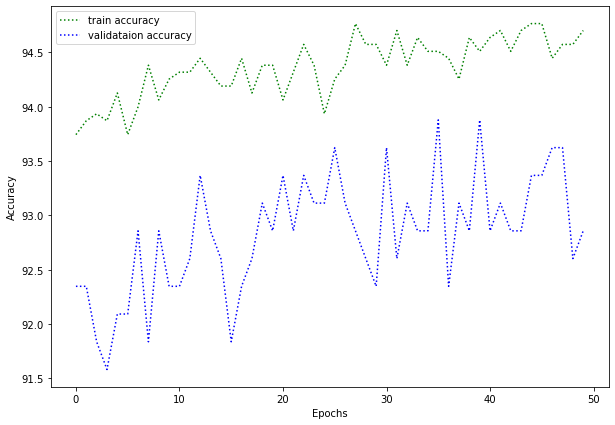

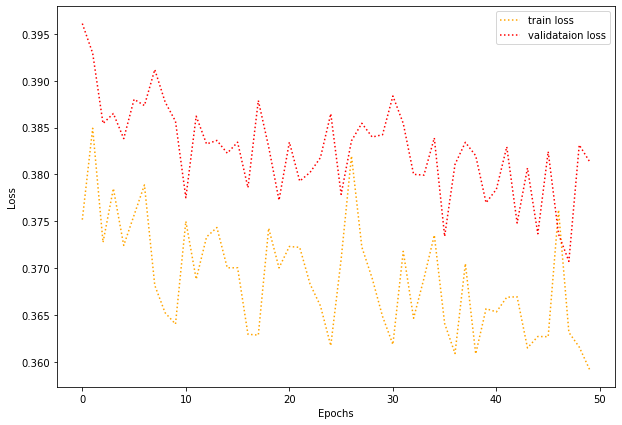

K =  5
[INFO]: Epoch 1 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.53it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.379, training acc: 94.508
Validation loss: 0.376, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.379, training acc: 94.508
Validation loss: 0.385, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.91it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.39it/s]


Training loss: 0.365, training acc: 94.508
Validation loss: 0.375, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.27it/s]


Training loss: 0.360, training acc: 94.891
Validation loss: 0.375, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.26it/s]


Training loss: 0.368, training acc: 94.828
Validation loss: 0.378, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.29it/s]


Training loss: 0.359, training acc: 94.381
Validation loss: 0.373, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.51it/s]


Training loss: 0.361, training acc: 94.700
Validation loss: 0.382, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.368, training acc: 94.700
Validation loss: 0.375, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.358, training acc: 94.444
Validation loss: 0.375, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.369, training acc: 94.636
Validation loss: 0.380, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.37it/s]


Training loss: 0.363, training acc: 94.764
Validation loss: 0.381, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.364, training acc: 94.636
Validation loss: 0.372, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.361, training acc: 94.381
Validation loss: 0.375, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.368, training acc: 94.764
Validation loss: 0.377, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.364, training acc: 94.572
Validation loss: 0.385, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.26it/s]


Training loss: 0.359, training acc: 94.636
Validation loss: 0.380, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.91it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.364, training acc: 94.828
Validation loss: 0.381, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.26it/s]


Training loss: 0.369, training acc: 94.828
Validation loss: 0.381, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.56it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.365, training acc: 94.636
Validation loss: 0.383, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.30it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.96it/s]


Training loss: 0.361, training acc: 95.083
Validation loss: 0.377, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 51.47it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.371, training acc: 94.636
Validation loss: 0.383, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.30it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.359, training acc: 94.508
Validation loss: 0.383, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.03it/s]


Training loss: 0.363, training acc: 95.019
Validation loss: 0.382, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.91it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.362, training acc: 94.508
Validation loss: 0.380, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.82it/s]


Training loss: 0.367, training acc: 94.572
Validation loss: 0.372, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.364, training acc: 94.891
Validation loss: 0.379, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.377, training acc: 94.508
Validation loss: 0.379, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.85it/s]


Training loss: 0.362, training acc: 94.891
Validation loss: 0.372, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.51it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.37it/s]


Training loss: 0.372, training acc: 94.828
Validation loss: 0.376, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 41.67it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.50it/s]


Training loss: 0.366, training acc: 94.764
Validation loss: 0.377, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.45it/s]


Training loss: 0.369, training acc: 94.700
Validation loss: 0.379, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 97.22it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.361, training acc: 94.636
Validation loss: 0.385, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.03it/s]


Training loss: 0.367, training acc: 94.764
Validation loss: 0.377, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.375, training acc: 94.253
Validation loss: 0.376, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.368, training acc: 95.019
Validation loss: 0.379, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.357, training acc: 95.083
Validation loss: 0.375, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.365, training acc: 94.636
Validation loss: 0.369, validation acc: 93.878

Best validation loss: 0.3690725415945053

Saving best model for epoch: 37

--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.364, training acc: 94.955
Validation loss: 0.373, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.96it/s]


Training loss: 0.361, training acc: 94.891
Validation loss: 0.377, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.356, training acc: 94.828
Validation loss: 0.369, validation acc: 93.367

Best validation loss: 0.36891351640224457

Saving best model for epoch: 40

--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.38it/s]


Training loss: 0.362, training acc: 94.700
Validation loss: 0.379, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.365, training acc: 94.955
Validation loss: 0.377, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.364, training acc: 95.147
Validation loss: 0.378, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 36.46it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 50.00it/s]


Training loss: 0.363, training acc: 94.700
Validation loss: 0.380, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.362, training acc: 94.955
Validation loss: 0.377, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 46.05it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.51it/s]


Training loss: 0.368, training acc: 94.828
Validation loss: 0.374, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 20.35it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.370, training acc: 94.764
Validation loss: 0.382, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 33.66it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.369, training acc: 94.828
Validation loss: 0.380, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.356, training acc: 95.211
Validation loss: 0.377, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 51.47it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.362, training acc: 94.700
Validation loss: 0.378, validation acc: 93.112
--------------------------------------------------
Saving final model...


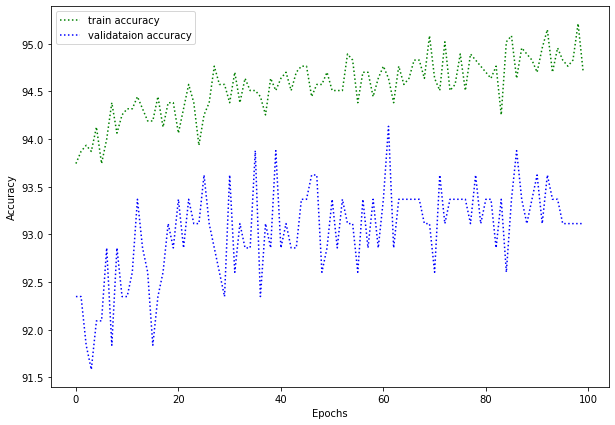

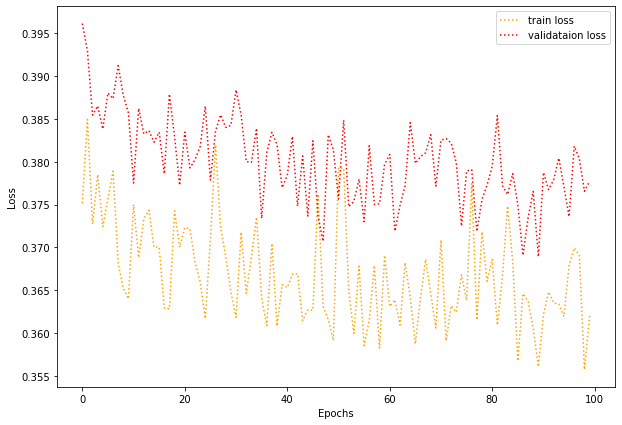

K =  7
[INFO]: Epoch 1 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.360, training acc: 94.955
Validation loss: 0.374, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.361, training acc: 95.083
Validation loss: 0.382, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.371, training acc: 94.381
Validation loss: 0.378, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 36.46it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 50.00it/s]


Training loss: 0.371, training acc: 94.764
Validation loss: 0.379, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.369, training acc: 94.891
Validation loss: 0.383, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.03it/s]


Training loss: 0.364, training acc: 94.444
Validation loss: 0.375, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 50.00it/s]


Training loss: 0.362, training acc: 94.764
Validation loss: 0.376, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.357, training acc: 94.636
Validation loss: 0.377, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.361, training acc: 94.636
Validation loss: 0.376, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.360, training acc: 95.019
Validation loss: 0.377, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 58.33it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.51it/s]


Training loss: 0.369, training acc: 94.700
Validation loss: 0.382, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.361, training acc: 94.828
Validation loss: 0.378, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.364, training acc: 95.019
Validation loss: 0.377, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.97it/s]


Training loss: 0.366, training acc: 94.636
Validation loss: 0.384, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.95it/s]


Training loss: 0.367, training acc: 94.636
Validation loss: 0.374, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.361, training acc: 94.891
Validation loss: 0.379, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 97.20it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.364, training acc: 94.700
Validation loss: 0.374, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.364, training acc: 94.828
Validation loss: 0.387, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.53it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.367, training acc: 95.019
Validation loss: 0.369, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.357, training acc: 94.891
Validation loss: 0.376, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.369, training acc: 94.828
Validation loss: 0.375, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.370, training acc: 94.444
Validation loss: 0.380, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 25.00it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.360, training acc: 95.147
Validation loss: 0.376, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 51.47it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.48it/s]


Training loss: 0.368, training acc: 94.955
Validation loss: 0.383, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.03it/s]


Training loss: 0.360, training acc: 95.083
Validation loss: 0.369, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.30it/s]


Training loss: 0.368, training acc: 94.891
Validation loss: 0.375, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.362, training acc: 94.508
Validation loss: 0.375, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.375, training acc: 94.636
Validation loss: 0.381, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 29.17it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.366, training acc: 95.083
Validation loss: 0.379, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 48.61it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.51it/s]


Training loss: 0.361, training acc: 94.700
Validation loss: 0.383, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.368, training acc: 94.891
Validation loss: 0.370, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.02it/s]


Training loss: 0.364, training acc: 94.955
Validation loss: 0.370, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.360, training acc: 94.828
Validation loss: 0.379, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.32it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.96it/s]


Training loss: 0.371, training acc: 94.764
Validation loss: 0.376, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.365, training acc: 94.764
Validation loss: 0.377, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.90it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.39it/s]


Training loss: 0.365, training acc: 94.955
Validation loss: 0.372, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 77.16it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.27it/s]


Training loss: 0.361, training acc: 95.083
Validation loss: 0.375, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 54.69it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.38it/s]


Training loss: 0.366, training acc: 94.891
Validation loss: 0.375, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.40it/s]


Training loss: 0.361, training acc: 95.019
Validation loss: 0.379, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 46.05it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.365, training acc: 94.828
Validation loss: 0.372, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.36it/s]


Training loss: 0.365, training acc: 94.700
Validation loss: 0.377, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 30.17it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 35.71it/s]


Training loss: 0.363, training acc: 95.275
Validation loss: 0.376, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.361, training acc: 94.700
Validation loss: 0.377, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.364, training acc: 94.955
Validation loss: 0.379, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.367, training acc: 94.508
Validation loss: 0.377, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.357, training acc: 94.891
Validation loss: 0.373, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.03it/s]


Training loss: 0.358, training acc: 94.955
Validation loss: 0.373, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.354, training acc: 95.466
Validation loss: 0.374, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.97it/s]


Training loss: 0.361, training acc: 94.955
Validation loss: 0.379, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.92it/s]


Training loss: 0.363, training acc: 95.338
Validation loss: 0.376, validation acc: 92.857
--------------------------------------------------
Saving final model...


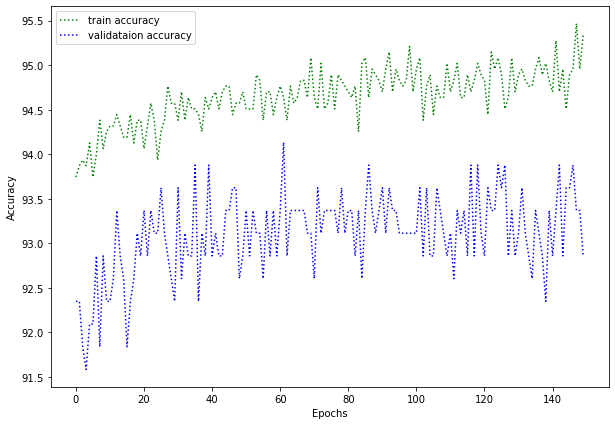

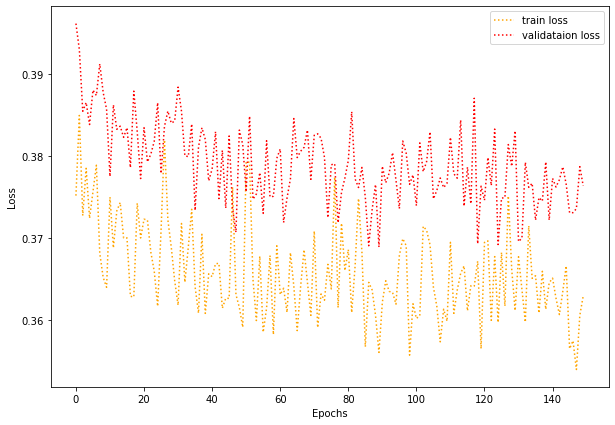

K =  21
[INFO]: Epoch 1 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 76.96it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.363, training acc: 94.700
Validation loss: 0.382, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.83it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.21it/s]


Training loss: 0.370, training acc: 94.508
Validation loss: 0.383, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 71.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.31it/s]


Training loss: 0.364, training acc: 94.189
Validation loss: 0.377, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 70.93it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 95.01it/s]


Training loss: 0.365, training acc: 94.572
Validation loss: 0.384, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 98.71it/s]


Training loss: 0.379, training acc: 94.381
Validation loss: 0.391, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 74.46it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.364, training acc: 94.253
Validation loss: 0.380, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 83.23it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.31it/s]


Training loss: 0.383, training acc: 94.381
Validation loss: 0.385, validation acc: 91.582
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 83.60it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 75.16it/s]


Training loss: 0.368, training acc: 94.061
Validation loss: 0.392, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 76.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.97it/s]


Training loss: 0.367, training acc: 94.253
Validation loss: 0.384, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.69it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.377, training acc: 94.317
Validation loss: 0.378, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.387, training acc: 93.934
Validation loss: 0.371, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.00it/s]


Training loss: 0.368, training acc: 94.125
Validation loss: 0.389, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 83.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.374, training acc: 94.381
Validation loss: 0.378, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 85.04it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.367, training acc: 94.381
Validation loss: 0.387, validation acc: 91.837
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 65.75it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.374, training acc: 94.125
Validation loss: 0.381, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.49it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.369, training acc: 94.636
Validation loss: 0.385, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 84.93it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.360, training acc: 94.189
Validation loss: 0.381, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 75.80it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 84.46it/s]


Training loss: 0.368, training acc: 94.572
Validation loss: 0.385, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.53it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.372, training acc: 94.572
Validation loss: 0.383, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 77.36it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 77.78it/s]


Training loss: 0.371, training acc: 94.317
Validation loss: 0.379, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 76.04it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.368, training acc: 94.572
Validation loss: 0.389, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 83.13it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.375, training acc: 94.253
Validation loss: 0.379, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.55it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Training loss: 0.374, training acc: 94.444
Validation loss: 0.378, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.03it/s]


Training loss: 0.374, training acc: 94.572
Validation loss: 0.383, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 80.89it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.369, training acc: 94.636
Validation loss: 0.385, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 78.79it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 214.44it/s]


Training loss: 0.360, training acc: 94.444
Validation loss: 0.383, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.361, training acc: 94.381
Validation loss: 0.384, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.369, training acc: 94.444
Validation loss: 0.377, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.363, training acc: 94.572
Validation loss: 0.383, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.97it/s]


Training loss: 0.371, training acc: 94.444
Validation loss: 0.378, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.02it/s]


Training loss: 0.388, training acc: 94.061
Validation loss: 0.384, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.365, training acc: 94.572
Validation loss: 0.382, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.97it/s]


Training loss: 0.373, training acc: 94.317
Validation loss: 0.378, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Training loss: 0.361, training acc: 94.317
Validation loss: 0.376, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.365, training acc: 94.700
Validation loss: 0.386, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.99it/s]


Training loss: 0.373, training acc: 94.572
Validation loss: 0.377, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.93it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.96it/s]


Training loss: 0.370, training acc: 94.444
Validation loss: 0.374, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 72.92it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.89it/s]


Training loss: 0.362, training acc: 94.381
Validation loss: 0.388, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 80.12it/s]


Training loss: 0.378, training acc: 94.508
Validation loss: 0.379, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 87.49it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]


Training loss: 0.368, training acc: 94.381
Validation loss: 0.379, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.31it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.31it/s]


Training loss: 0.366, training acc: 94.381
Validation loss: 0.378, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 79.54it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.360, training acc: 94.700
Validation loss: 0.381, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 71.63it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 49.99it/s]


Training loss: 0.369, training acc: 94.508
Validation loss: 0.379, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 54.71it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Training loss: 0.366, training acc: 94.764
Validation loss: 0.388, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.50it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 125.30it/s]


Training loss: 0.358, training acc: 94.828
Validation loss: 0.382, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.52it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 62.50it/s]


Training loss: 0.368, training acc: 94.572
Validation loss: 0.380, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 62.49it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.28it/s]


Training loss: 0.360, training acc: 94.636
Validation loss: 0.382, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 67.32it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.97it/s]


Training loss: 0.361, training acc: 94.700
Validation loss: 0.388, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 29.99it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Training loss: 0.390, training acc: 94.061
Validation loss: 0.387, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 7/7 [00:00<00:00, 80.07it/s]


Validation


100%|██████████| 2/2 [00:00<00:00, 124.93it/s]


Training loss: 0.361, training acc: 94.381
Validation loss: 0.385, validation acc: 92.602
--------------------------------------------------
Saving final model...


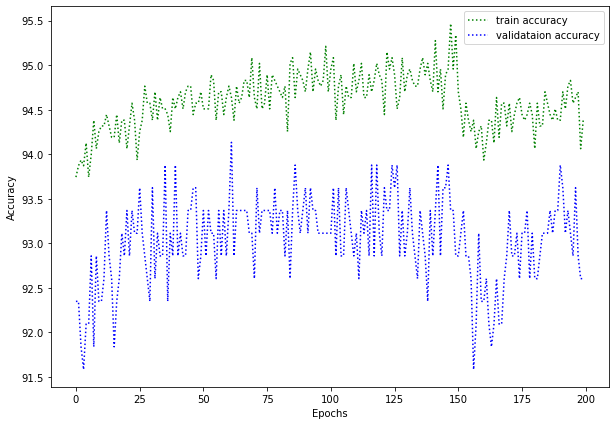

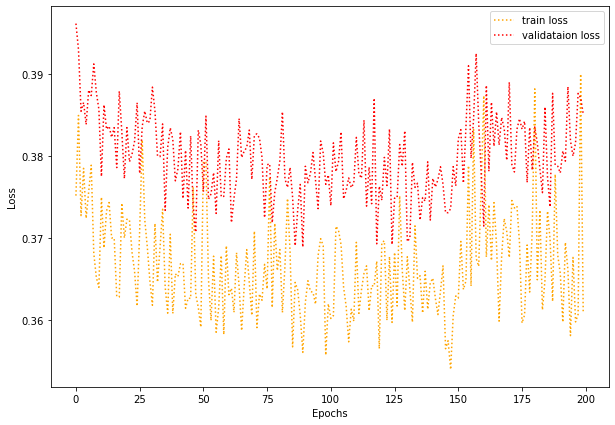

K =  63
[INFO]: Epoch 1 of 50
Training


 86%|████████▌ | 6/7 [00:00<00:00, 75.03it/s]


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 30, n_neighbors = 63

In [50]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
epochs = 50
k_list = [3,5,7,21, 63]
# start the training
for k in k_list:
    print("K = ",k)
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        #optimizer = exp_lr_scheduler(optimizer_ft, epochs)
        train_epoch_loss, train_epoch_acc = train(model, train_loader,optimizer_ft, criterion,k)
        valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,criterion,k)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        # save the best model till now if we have the least loss in the current epoch
        save_best_model(valid_epoch_loss, epoch, model, optimizer_ft, criterion,k)
        print('-'*50)
    
    # save the trained model weights for a final time
    save_model(epochs, model, optimizer_ft, criterion)
    # save the loss and accuracy plots
    save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

In [52]:
# Test the model on test samples

confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
for k in k_list:
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            inputs = inputs.squeeze()
            adj_matrix = nearestneighbours(inputs,k)
            adj_matrix = adj_matrix.to(device)
            #edge = edge_finder(adj_matrix)
            outputs = model(inputs.unsqueeze(0),adj_matrix.unsqueeze(0))
            #outputs = model(feats, adj_matrix, edge, 0)
            outputs = outputs.squeeze()
            fl_pred = outputs.argmax(dim=1)
        
            p=precision_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            r=recall_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            f=f1_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            print('F1: {}'.format(f))
            print('Precision: {}'.format(p))
            print('Recall: {}'.format(r))
            print(classification_report(classes.cpu(),fl_pred.cpu()))

F1: 0.94921875
Precision: 0.94921875
Recall: 0.94921875
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       121
           1       0.94      0.97      0.95       135

    accuracy                           0.95       256
   macro avg       0.95      0.95      0.95       256
weighted avg       0.95      0.95      0.95       256

F1: 0.9631147540983607
Precision: 0.9631147540983607
Recall: 0.9631147540983607
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       129
           1       0.96      0.96      0.96       115

    accuracy                           0.96       244
   macro avg       0.96      0.96      0.96       244
weighted avg       0.96      0.96      0.96       244

F1: 0.95703125
Precision: 0.95703125
Recall: 0.95703125
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       121
           1       0.96      0.96      0.96  

K =  3
Accuracy on test data: 0.96
Precison:  0.968503937007874
Recall:  0.984
F1-Score : 0.976190476190476


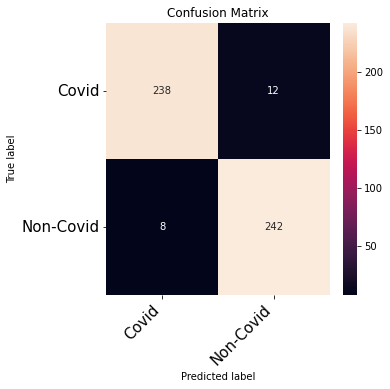

K =  5
Accuracy on test data: 0.956
Precison:  0.9421487603305785
Recall:  0.957983193277311
F1-Score : 0.95


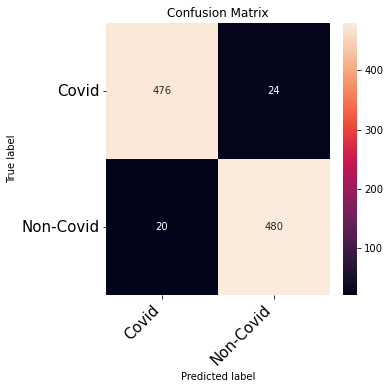

K =  7
Accuracy on test data: 0.9546666666666667
Precison:  0.968503937007874
Recall:  0.9534883720930233
F1-Score : 0.9609375


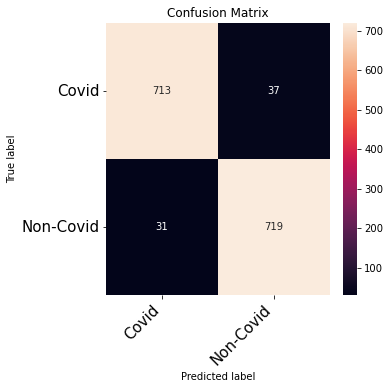

K =  21
Accuracy on test data: 0.952
Precison:  0.9322033898305084
Recall:  0.9166666666666666
F1-Score : 0.9243697478991596


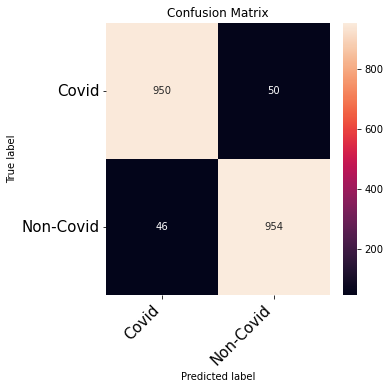

K =  63
Accuracy on test data: 0.9504
Precison:  0.96
Recall:  0.9230769230769231
F1-Score : 0.9411764705882353


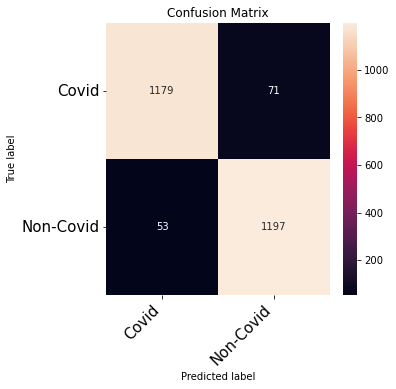

In [55]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
for k in k_list:
        print("K = ",k)
        with torch.no_grad():
                for i, (inputs, classes) in enumerate(test_loader):
                        inputs = inputs.to(device)
                        classes = classes.to(device)
                        inputs = inputs.squeeze()
                        adj_matrix = nearestneighbours(inputs,k)
                        adj_matrix = adj_matrix.to(device)
                        
                        outputs =  model(inputs.unsqueeze(0),adj_matrix.unsqueeze(0))
                        #outputs = model(feats, adj_matrix, edge, 0)
                        outputs = outputs.squeeze()
                        _, preds = torch.max(outputs, 1)
            
                        for t, p in zip(classes.view(-1), preds.view(-1)):
                                confusion_matrix[t.long(), p.long()] += 1
                
        print(f"Accuracy on test data: {confusion_matrix.diagonal().sum()/confusion_matrix.sum()}")
        print("Precison: ", precision_score(preds, classes))
        print("Recall: ",recall_score(preds, classes))
        print("F1-Score :", f1_score(preds, classes))
        plt.figure(figsize=(5,5))

        class_names = ['Covid','Non-Covid']
        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()

In [100]:
torch.save(model,'ResGnn.pt')